# IRC Behavioral Analysis

### Imports

In [5]:
import zat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from zat.log_to_dataframe import LogToDataFrame
from zat.bro_log_reader import BroLogReader
from collections import defaultdict

## Loading Data

In [6]:
import os

log_names_mal = ['03','04','34','39','42','51','56','62']
log_names_benign = ['irc1']
log_names = log_names_mal + log_names_benign

# project_dir = '/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/'
project_dir = '/home/prenek/IRC-Behavioral-Analysis/'
log_dir = os.path.join(project_dir, 'zeek/logs/')
out_dir = os.path.join(project_dir, 'python/out/')

fileout_join_freq = 'join_freq.log'
fileout_lev_dist = 'lev_dist.log'

logs_fn_join = [os.path.join(log_dir,l,'irc_join.log') for l in log_names]
logs_fn_join_mal = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]
logs_fn_join_benign = [os.path.join(log_dir,l,'irc_join.log') for l in log_names_mal]

logs_fn_privmsg = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names]
logs_fn_privmsg_mal = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_mal]
logs_fn_privmsg_benign = [os.path.join(log_dir,l,'irc_privmsg.log') for l in log_names_benign]

In [7]:
def load_logs(file):
    logs_arr = []
    if not os.path.isfile(file):
        return logs_arr
    
    reader = BroLogReader(file)
    for log in reader.readrows():
        # log is in dictionary format
        logs_arr.append(log)

    return logs_arr

In [8]:
logs_join_mal = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join_benign = list(map(lambda x: load_logs(x),logs_fn_join))
logs_join = logs_join_mal + logs_join_benign


logs_privmsg_mal = list(map(lambda x: load_logs(x),logs_fn_privmsg_mal))
logs_privmsgmal = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_mal]

logs_privmsg_benign = list(map(lambda x: load_logs(x), logs_fn_privmsg_benign))
logs_privmsg_benign = [list(filter(lambda x: x['target'].startswith('#'), log)) for log in logs_privmsg_benign]
logs_privmsg = logs_privmsg_mal + logs_privmsg_benign

Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/04/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/34/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/39/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/42/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/51/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/56/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/62/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/irc1/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/04/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/34/irc_join.log...
Successfully monitoring /home/prenek/IRC-Behavioral-Analysis/zeek/logs/39/irc_join.log...
Successf

### Divide logs by channels

In [9]:
from collections import defaultdict
logs_join_divided = []
for logs in logs_join:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['channel']].append(log)
    logs_join_divided.append(logs_per_channel)

In [10]:
logs_privmsg_benign_divided = []
for logs in logs_privmsg_benign:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_benign_divided.append(logs_per_channel)

In [11]:
logs_privmsg_mal_divided = []
for logs in logs_privmsg_mal:
    logs_per_channel = defaultdict(lambda: [])    
    for log in logs:
        logs_per_channel[log['target']].append(log)
    logs_privmsg_mal_divided.append(logs_per_channel)

## Number of Users in Channel per Day

In [23]:
import json

def ircjoin_compute(logs):
    if len(logs) == 0:
        return None, None

    logs_ts = list(map(lambda x: x['ts'].date(), logs))

    # first ts of join command
    ts_min = min(logs_ts)
    ts_max = max(logs_ts)
#     print('min date: {}, max date: {}'.format(ts_min, ts_max))
    span = ts_max - ts_min
    
    dates = [ts_min+timedelta(days=i) for i in range(span.days+1)]

    ## count how many join commands are in which day 
    logs_per_day = defaultdict(lambda: 0)
    for v in logs_ts:
        logs_per_day[v] += 1
    
    dates_count = []
    count = 0
    for d in dates:
        count += logs_per_day[d]
        dates_count.append(count)
    
    return dates, dates_count


def ircjoin_visualize(dates, dates_count):
    plt.bar(dates,dates_count)
    plt.show()

### Data export into CSV

In [24]:
print('ircjoin...')
for ln, l in zip(log_names, logs_join_divided):
   fn = os.path.join(out_dir, ln, fileout_join_freq)
   df_join = pd.DataFrame(columns=['channel','date','users_count'])
   
   for l_k in l.keys():
       log = l[l_k]
       d_arr, dc_arr = ircjoin_compute(log)
       # ircjoin_visualize(d, dc)
       for d, dc in zip(d_arr,dc_arr):
           df_join = df_join.append({'channel': l_k, 'date': d, 'users_count': dc}, ignore_index=True)
   
   print(fn)
   df_join.to_csv(fn, sep=';', encoding='utf-8')

ircjoin...
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/03/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/04/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/34/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/39/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/42/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/51/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/56/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/62/join_freq.log
/Users/preneond/Documents/Work/Stratosphere/IRC-Research/IRC-Behavioral-Analysis/python/out/irc1/join_freq.log


### Reading exported all csv and merging it into one 

In [12]:
# print('ircjoin...')
# df_join = pd.DataFrame(columns=['channel','date','users_count', 'pcap', 'malicious'])
# for ln in log_names_mal:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
   
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                   'date': df_el['date'],
#                                   'users_count': df_el['users_count'],
#                                   'pcap': ln,
#                                   'malicious': 1
#                                  }, ignore_index=True)
   
# for ln in log_names_benign:
#     fn = os.path.join(out_dir, ln, fileout_join_freq)
#     df_join_tmp = pd.read_csv(fn, sep=';', encoding='utf-8')
#     for i, df_el in df_join_tmp.iterrows():
#         df_join = df_join.append({'channel': df_el['channel'],
#                                       'date': df_el['date'],
#                                       'users_count': df_el['users_count'],
#                                       'pcap': ln,
#                                       'malicious': 0
#                                      }, ignore_index=True)

df_join = pd.read_csv(os.path.join(out_dir, 'join_freq_all.csv'))

## Levenshtein Distance of Messages in Channel

In [69]:
import itertools
from Levenshtein import distance as levenshtein_distance

def compute_levenshtein_distance(logs_msg):
    combs = itertools.combinations(logs_msg, 2)
    dist_lev_arr = []
    for msg1, msg2 in combs:
        dist_lev_arr.append(levenshtein_distance(msg1,msg2))
        
#     return dt_lev_arr

### Bubble plot

In [70]:
from multiprocessing import Pool

n = len(logs_privmsg_divided)

print('ircprivmsg..')

def compute_lev_dist_per_channel(fn, l_k):
    print('channel: ', l_k)
    # compute levenshtein distance
    logs_msg = [log['msg'] for log in logs_div[l_k]]
    logs_lev_dist = compute_levenshtein_distance(logs_msg)
    # compute number of msg's senders per channel
    sources = set([log['source'] for log in logs_div[l_k]])
    print('sources: ', len(sources))

    df = pd.DataFrame([{'channel': l_k, 'num_sources': len(sources), 'lev_dist': logs_lev_dist}])
    

    if not os.path.isfile(fn):
        print('creating csv file....')
        df.to_csv(fn, header='column_names')
    else:
        print('csv file exists.')
        df.to_csv(fn, mode='a', header=False)

    return df


for ln, logs_div in zip(log_names_benign, logs_privmsg_divided):
    with Pool() as pool:
        fn = os.path.join(out_dir, ln, fileout_lev_dist)
        # loop through channels            
        data = pool.starmap(compute_lev_dist_per_channel, itertools.product([fn], logs_div.keys()))     

channel:  ##Summit
channel:  #Runz
channel:  #007
channel:  #kz
channel:  #all
channel:  #x
channel:  #root
channel:  #o


## Channel Language Recognition

In [14]:
from textblob import TextBlob
import pycountry
from collections import defaultdict
from itertools import chain
import re
## Create a text corpus for each file
def load_corpus(logs, pcap):
    corp_ch = set(filter(lambda x: len(x) > 2, chain.from_iterable(chain.from_iterable(map(lambda x: [re.findall(r"[a-zA-Z]+", w) for w in x['msg'].split()], logs)))))
    return corp_ch

## Malicious Samples

Compute message corpus per each channels

In [49]:
# logs_in = logs_privmsg_mal_divided
# load_corpus(logs_in)
corpus_df_mal = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_mal, logs_privmsg_mal_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_mal = corpus_df_mal.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect languages

In [50]:
for i, c in corpus_df_mal.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_mal.iloc[i]['lang'] =  lang

HTTPError: HTTP Error 429: Too Many Requests

### Plotbar - channels

,pcap,corpus,lang,channel
0,34,"{region, RAWUDP, yet, Realtek, ircs, same, the...",English,##Summit
1,42,{},Unidentifiable,#Runz
2,51,"{tmp, mountfs, join, all, nproc, var, days, lo...",English,#007
3,51,"{awk, var, tar, lvmetad, curl, sed, auxwww, de...",English,#all
4,51,"{awk, var, tar, pkill, curl, sed, auxwww, rgz,...",English,#kz


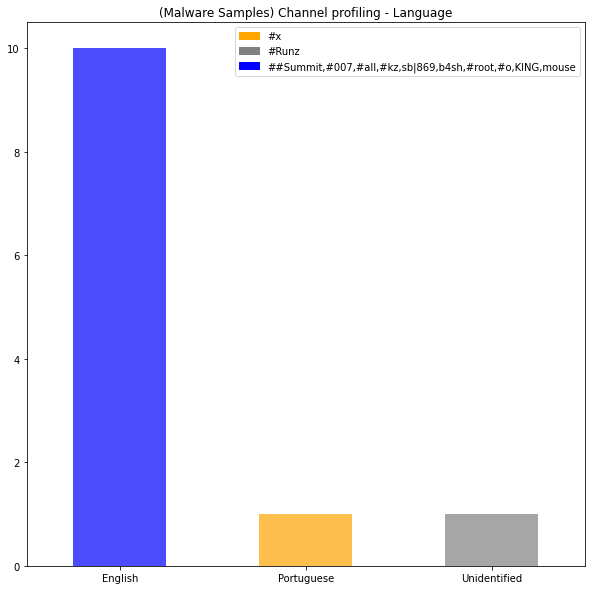

In [131]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['channel'])))
UN = mpatches.Patch(color='gray', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['channel'])))
ENG = mpatches.Patch(color='blue', label= ",".join(list(corpus_df_mal[corpus_df_mal['lang'] == 'English']['channel'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

### Plotbar - pcaps

In [ ]:
# # corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(10,10))

myplot = corpus_df_mal['lang'].value_counts().plot(kind='bar', color =['blue','orange','gray'], title='(Malware Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches
POR = mpatches.Patch(color='orange', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Portuguese']['pcap'])))
UN = mpatches.Patch(color='gray', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'Unidentified']['pcap'])))
ENG = mpatches.Patch(color='blue', label= ",".join(set(corpus_df_mal[corpus_df_mal['lang'] == 'English']['pcap'])))
myplot.legend(handles=[POR,UN,ENG])

plt.xticks(rotation=0)

## Benign Samples

Compute message corpus per each channels

In [15]:
corpus_df_benign = pd.DataFrame(columns=['pcap','corpus','lang'])
for ln, logs in zip(log_names_benign, logs_privmsg_benign_divided):
    for channel in logs.keys():
        corpus = load_corpus(logs[channel], ln)
        corpus_df_benign = corpus_df_benign.append({'pcap': ln, 'channel': channel, 'corpus': corpus}, ignore_index=True)

Detect language

In [ ]:
for i, c in corpus_df_benign.iterrows():
    pcap = c['pcap']
    text = " ".join(c['corpus'])
    lang = "Unidentified"
    if len(text) > 2:
        code = TextBlob(text).detect_language()
        lang = pycountry.languages.get(alpha_2=code).name
    corpus_df_benign.iloc[i]['lang'] =  lang

### Plotbar - channels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

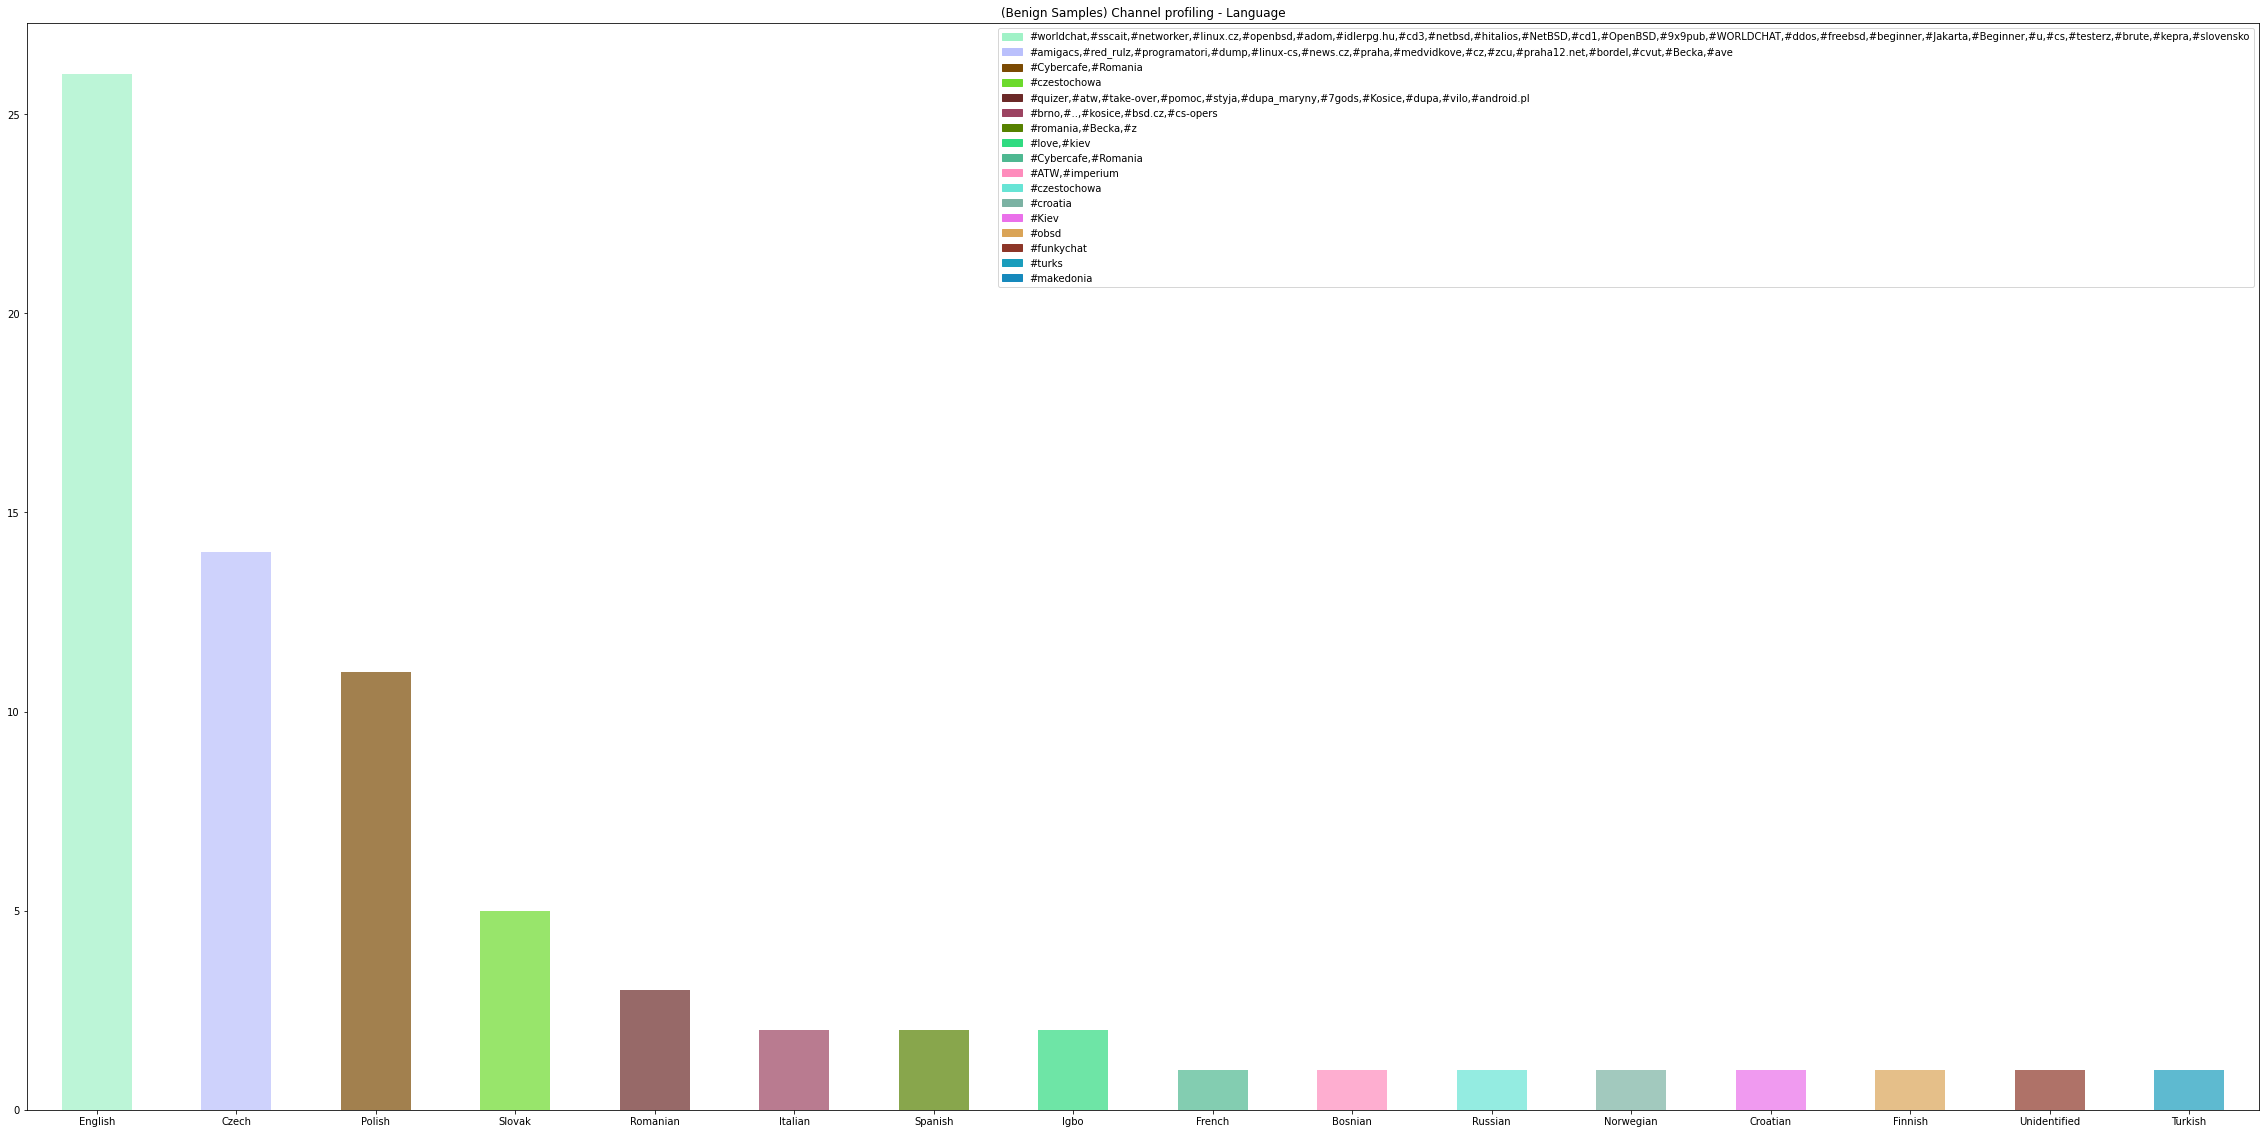

In [42]:
import random
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(list(corpus_df_benign[corpus_df_benign['lang'] == lang]['channel'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)

### Plotbar - pcaps

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

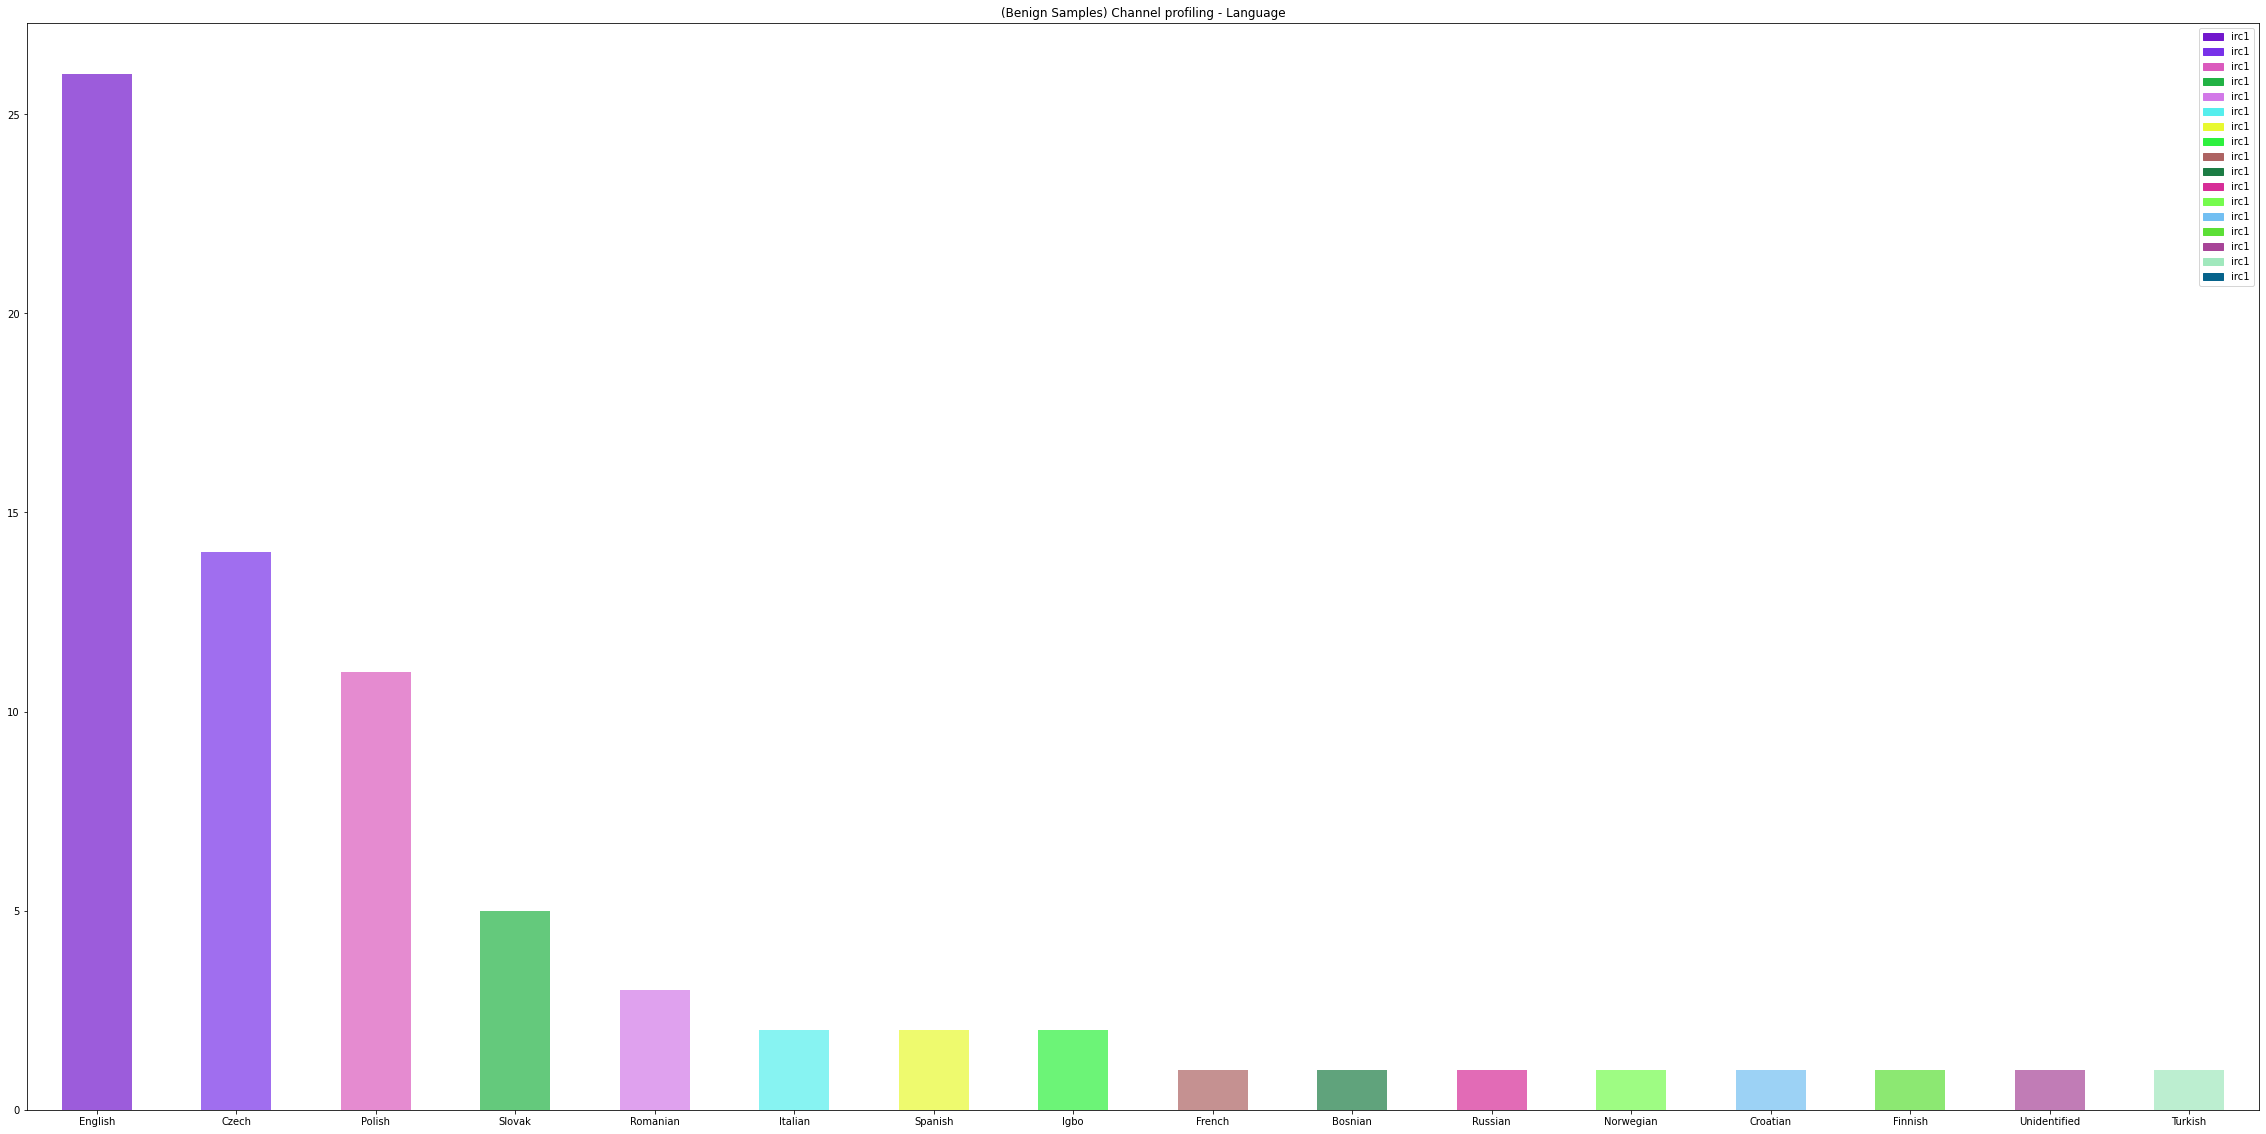

In [47]:
# corpus_df.plot.pie(y='lang', figsize=(5,5))    
fig = plt.figure(figsize=(40,20))
rgb = [(random.random(), random.random(), random.random()) for i in range(corpus_df_benign.shape[0])]
langs = ['English', 'Czech', 'Spanish', 'French', 'Polish','Slovak',
         'Romanian', 'Italian', 'Spanish', 'Igbo', 'French','Bosnian',
         'Russian', 'Norwegian', 'Finnish', 'Turkish', 'Unidentified']
myplot = corpus_df_benign['lang'].value_counts().plot(kind='bar', color=rgb, title='(Benign Samples) Channel profiling - Language', alpha=0.7)
import matplotlib.patches as mpatches

handle_arr = []
for c, lang in zip(rgb, langs):
    h = mpatches.Patch(color=c, label= ",".join(set(corpus_df_benign[corpus_df_benign['lang'] == lang]['pcap'])))
    handle_arr.append(h)

myplot.legend(handles=handle_arr)

plt.xticks(rotation=0)